# Carve up Spatiotemporal Space with Oriented Gabors

Adelson & Bergen equations dont easily tile spatiotemporal space, so lets start with the simplest thing and extend gabors into space-time. We carve up the spatiotemporal space with gabors, starting in 2d, then 3d

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from matplotlib import cm
pi = np.pi

In [2]:
def gauss_filter_2d(x, y, mu_x, mu_y, sigma_x, sigma_y, norm=True):
    response = np.exp(-((x - mu_x)**2 / (2 * sigma_x**2) + (y - mu_y)**2 / (2 * sigma_y**2)))
    if norm:
        reseponse = response / (sigma_x * sigma_y * 2*np.pi)
    return(response)
    
def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return x, y

def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def polar_gaussian_2d(xs,ys, scale, orientation, phase_offset=0, norm=True):
    #calculte the center of the gaussian
    mu_x, mu_y = pol2cart(scale,orientation)
    #by scaling of 0.4 for V1 (freeman & simoncelli), the sigma width should be 0.4 of the radius (is this right?)
    scaling_factor = 0.4
    filt_sigma = scale * scaling_factor
    filt = gauss_filter_2d(xs,ys,mu_x,mu_y,filt_sigma,filt_sigma,norm=norm)
    #add phase offset
    filt = filt * np.exp(1j * phase_offset)
    return(filt)

def quadrature_gaussian_filter(xs, ys, scale, orientation,norm=True):
    #to make this look like a standard gabor, need to have phase offsets of pi/4 and 3pi/4. I'm not sure why this is.
    # Real part: Gaussian with no phase shift in the top quadrants
    filter_real = polar_gaussian_2d(xs, ys, scale, orientation, phase_offset=0,norm=True)
    # Imaginary part: Gaussian with a 90-degree phase shift in teh bottom quadrants
    filter_imag = polar_gaussian_2d(xs, ys, scale, orientation+np.pi, phase_offset=pi,norm=True)
    # Combine into a complex filter
    filter = filter_real + 1j*filter_imag
    return filter

## Plot a Demo

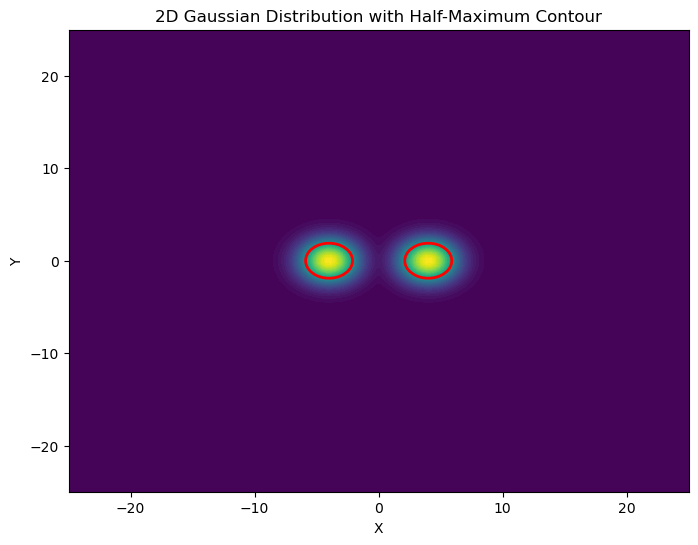

In [3]:
#setup space and time progression
space = np.linspace(-25,25,num=150)
time = np.linspace(-25,25,num=150)
xs,ys = np.meshgrid(space,time)
#pick a scale and orientation
scale = 4
orientation = 0

# Calculate the 2D Gaussian surface
filter = quadrature_gaussian_filter(xs, ys, scale, orientation,norm=True)
#get just the amplitude for now
filter = np.abs(filter)

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xs, ys, filter, levels=50)
# cbar = fig.colorbar(conxstoysr)filter# cbar.set_label('Intensity')
# Add a contour to show where the value is half of the maximum
half_max_contour = ax.contour(xs, ys, filter, levels=[np.max(filter) / 2], colors='red', linestyles='-', linewidths=2)
#ax.clabel(half_max_contour, inline=1, fontsize=10, fmt='Half max: %.2f')

# Additional plot settings
ax.set_title('2D Gaussian Distribution with Half-Maximum Contour')
ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.show()

## Add Two Together

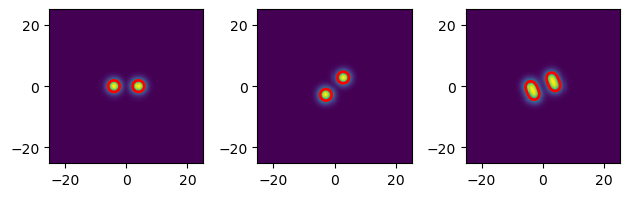

In [4]:
filter1 = quadrature_gaussian_filter(xs,ys,4,0,norm=True)
filter2 = quadrature_gaussian_filter(xs,ys,4,np.pi/4,norm=True)

#get just the amplitude for now
filter1 = np.abs(filter1)
filter2 = np.abs(filter2)

plt.subplot(1,3,1,aspect=1)
plt.pcolormesh(xs, ys, filter1, shading='auto')
plt.contour(xs,ys, filter1, levels=[np.max(filter1) / 2], colors='red', linestyles='-', linewidths=2)
plt.subplot(1,3,2,aspect=1)
plt.pcolormesh(xs,ys, filter2, shading='auto')
plt.contour(xs,ys, filter2, levels=[np.max(filter2) / 2], colors='red', linestyles='-', linewidths=2)
plt.subplot(1,3,3,aspect=1)
plt.pcolormesh(xs,ys, filter1 + filter2, shading='auto')
plt.contour(xs,ys, filter1 + filter2, levels=[np.max(filter1+filter2) / 2], colors='red', linestyles='-', linewidths=2)
plt.tight_layout()

## Go through a range of scales and orientations and plot them all

/state/partition1/slurm_tmp/26443615.0.0/ipykernel_2763179/4169511297.py:19: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(len(orientations),len(scales),i*len(scales)+j+1, aspect=1)


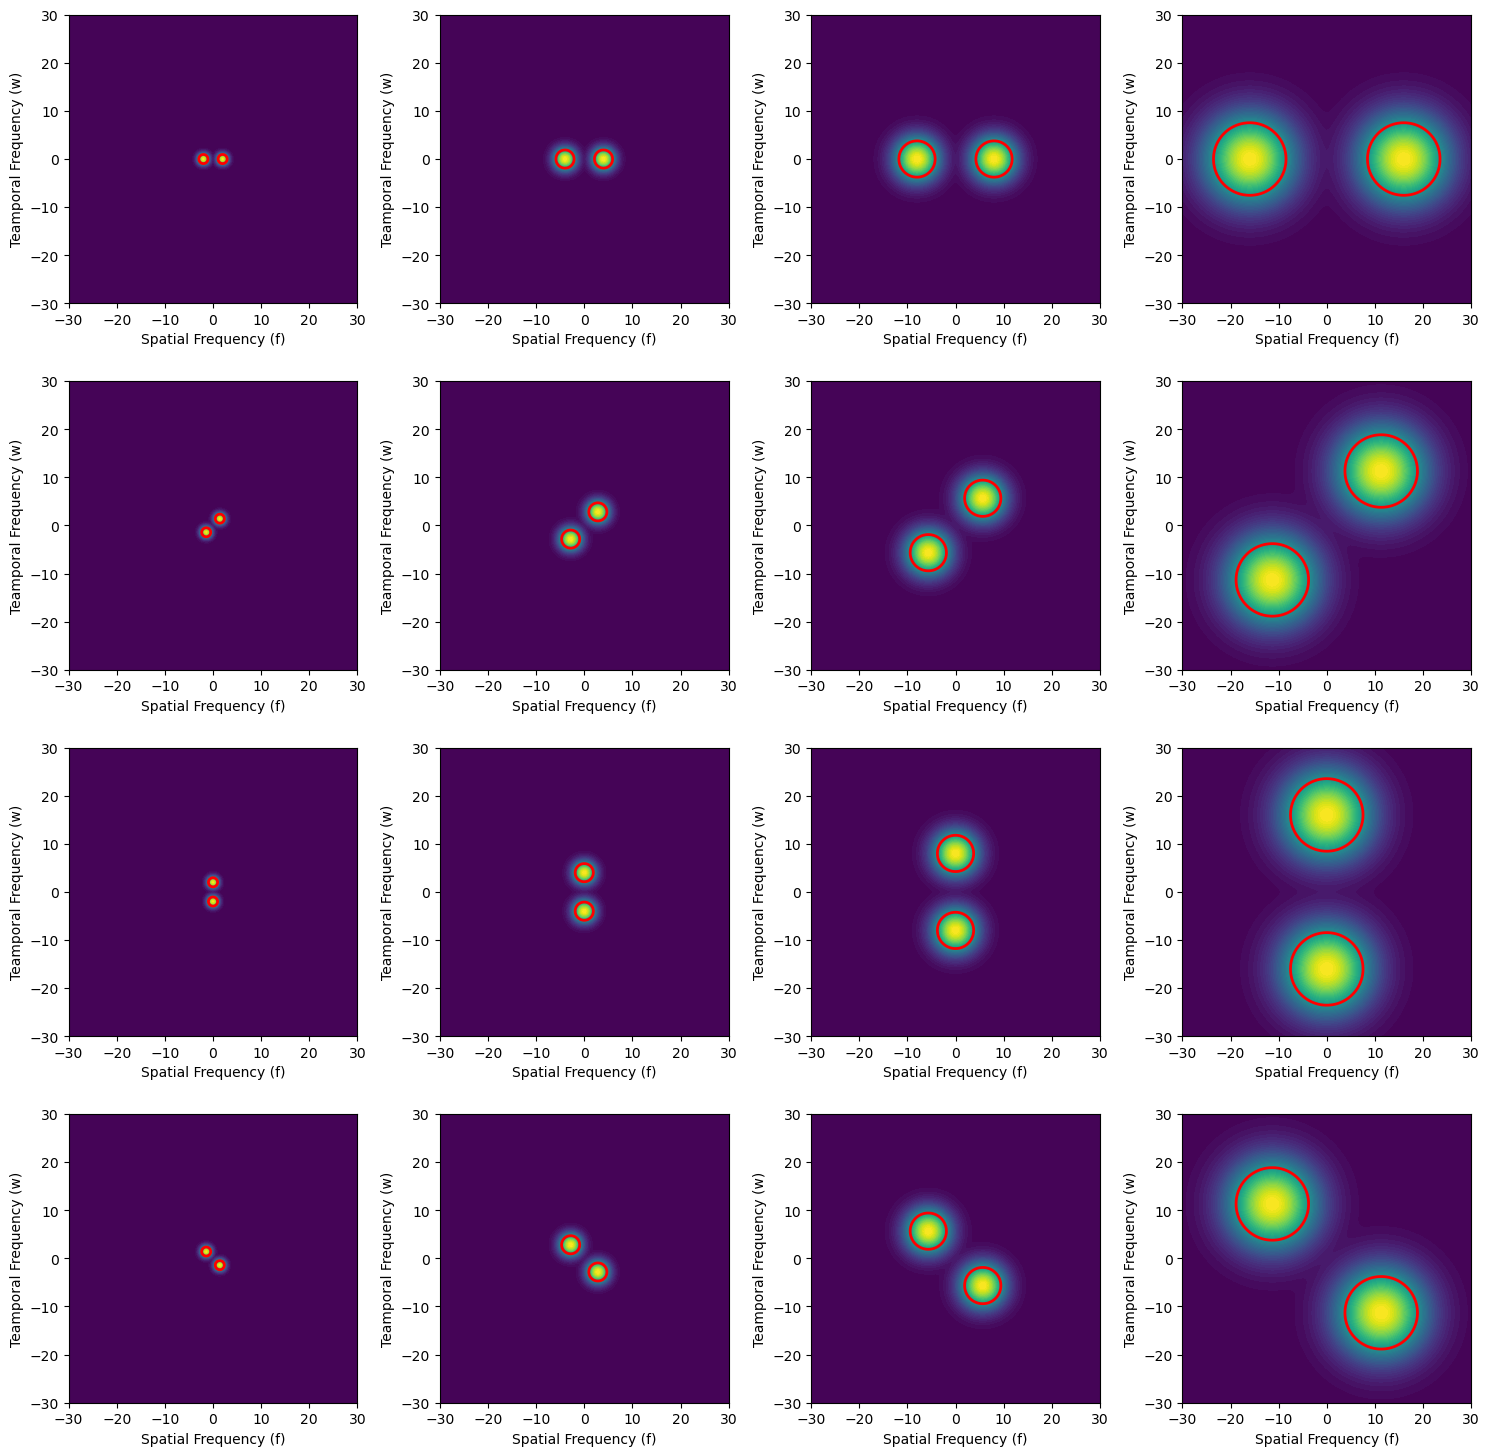

In [5]:
#pick our scales & centers
scales = [2,4,8,16]
orientations = [0,pi/4,pi/2,3*pi/4]
#orientations_odd = [pi,5*pi/4,3*pi/2,7*pi/4]
#orientations = orientations_even + orientations_odd
#setup space and time progression
space = np.linspace(-30,30,num=200)
time = np.linspace(-30,30,num=200)
xs,ys = np.meshgrid(space,time)

#plot these all
fig,ax = plt.subplots(figsize=(15,15))
for i, orientation in enumerate(orientations):
    for j, scale in enumerate(scales):
        #create filter
        filter = quadrature_gaussian_filter(xs,ys,scale,orientation)
        filter = np.abs(filter)
        #plot it
        plt.subplot(len(orientations),len(scales),i*len(scales)+j+1, aspect=1)
        plt.contourf(xs, ys, filter, levels=50)
        plt.contour(xs, ys, filter, levels=[np.max(filter) / 2], colors='red', linestyles='-', linewidths=2)
        #plt.pcolormesh(space, time, filter, shading='auto',cmap='Greys_r')
        #plt.fill_between(x, y, where=((x > half_max_x1) & (x < half_max_x2)), color='gray', alpha=0.5, label='FWHM Area')
        #plt.axvline(half_max_x1, color='b', linestyle='--', label='FWHM Boundaries')
        plt.xlabel('Spatial Frequency (f)')
        plt.ylabel('Teamporal Frequency (w)')
        #plt.colorbar()
        plt.tight_layout()

## Plot them all on the same axis to see if this makes sense

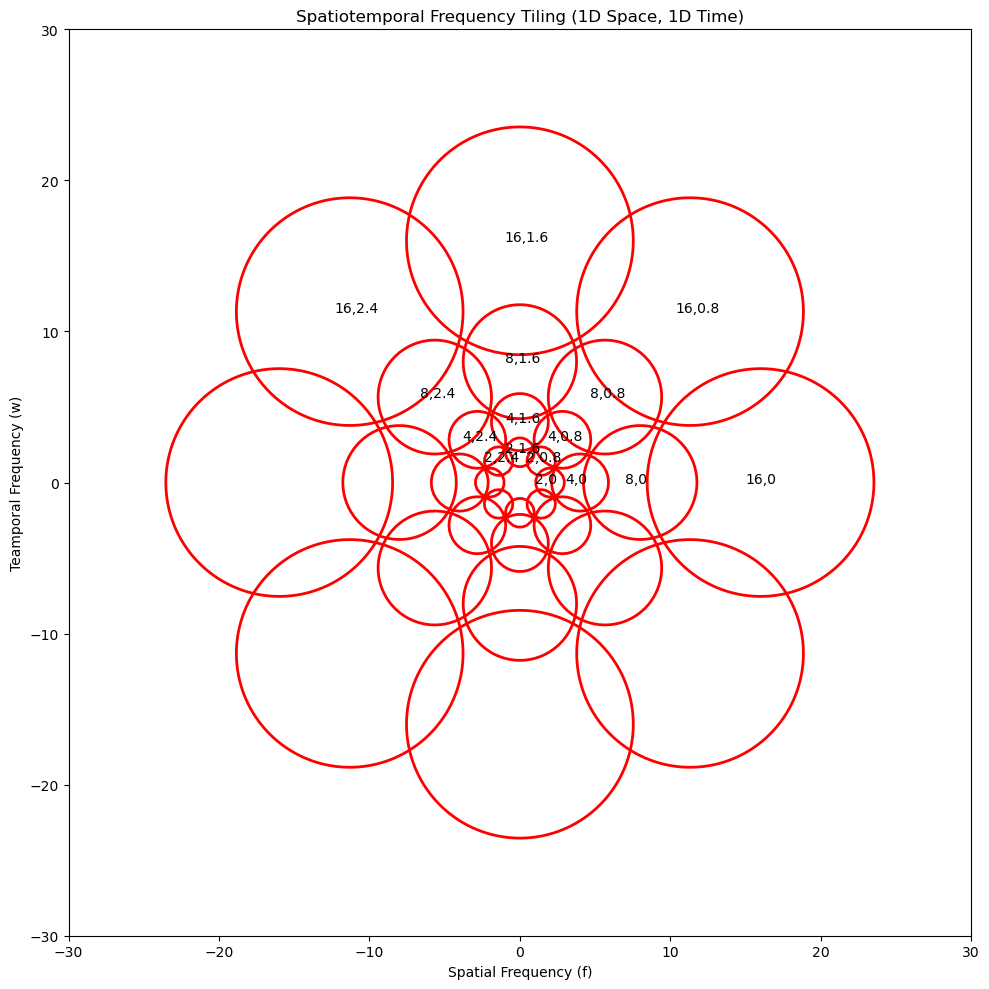

In [6]:
#plot these all
fig,ax = plt.subplots(figsize=(10,10))
for i, orientation in enumerate(orientations):
    for j, scale in enumerate(scales):
        #create filter
        filter = quadrature_gaussian_filter(xs,ys,scale,orientation)
        filter = np.abs(filter)
        #plot it
        #plt.contourf(xs, ys, filter, levels=50, cmap='Greys_r')
        plt.contour(xs, ys, filter, levels=[np.max(filter) / 2], colors='red', linestyles='-', linewidths=2)

        #label each filter 
        mu_x, mu_y = pol2cart(scale,orientation)
        text_offset = 1
        plt.text(mu_x-text_offset, mu_y, f'{scale},{np.round(orientation,1)}', fontsize=10)
        #plt.pcolormesh(space, time, filter, shading='auto',cmap='Greys_r')
        #plt.fill_between(x, y, where=((x > half_max_x1) & (x < half_max_x2)), color='gray', alpha=0.5, label='FWHM Area')
        #plt.axvline(half_max_x1, color='b', linestyle='--', label='FWHM Boundaries')
plt.xlabel('Spatial Frequency (f)')
plt.ylabel('Teamporal Frequency (w)')
plt.title('Spatiotemporal Frequency Tiling (1D Space, 1D Time)')
#plt.colorbar()
plt.tight_layout()

## How do these look in space/time filter domain?
These filters were created in the fourier domain, what do they look lik in the spatial domain?

Fourier filter is symmetric: True


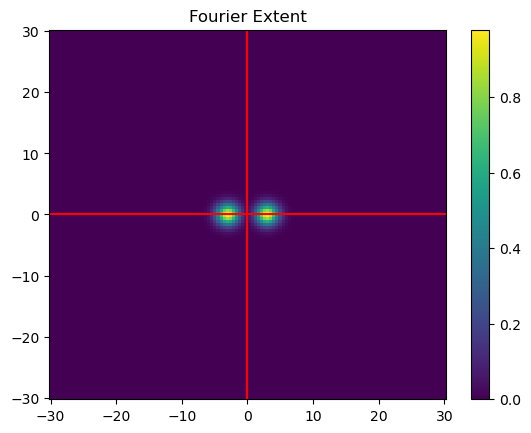

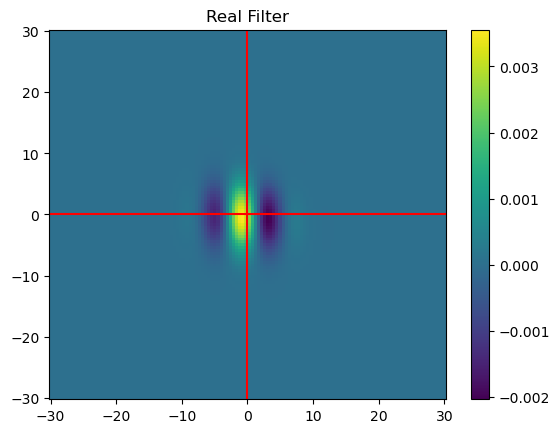

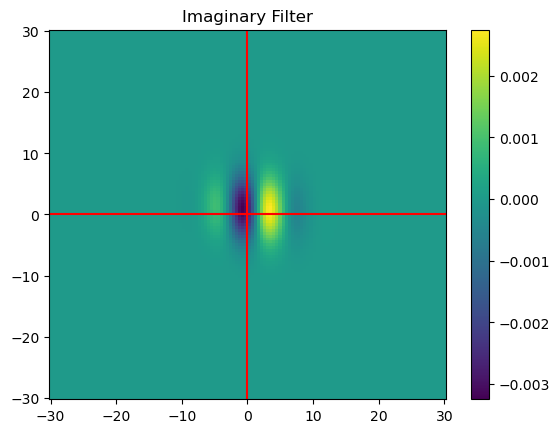

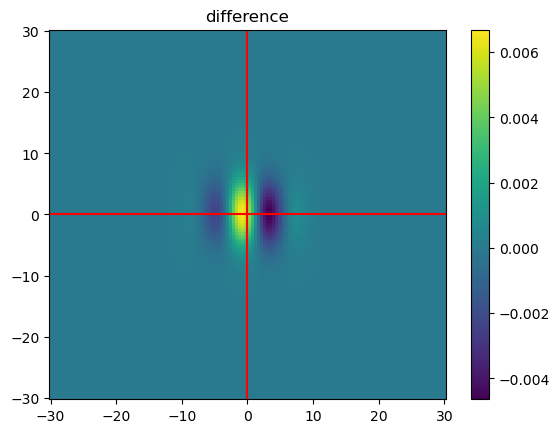

In [7]:
#demo one
def inverse_power_spec(filter):
    #complex_spec = ampspec * np.exp(1j * np.zeros_like(ampspec))
    filter = np.fft.ifft2(np.fft.ifftshift(filter)) #unshift 
    filter = np.fft.fftshift(filter)
    filter_real = np.real(filter) #real pair filter
    filter_imag = np.imag(filter) #imag pair filter
    return(filter_real,filter_imag)

#c/o chatgpt
def check_fourier_symmetry(F):
    # Check if the Fourier transform F has Hermitian symmetry
    # F should be a 2D array
    return np.allclose(F, np.conj(np.flipud(np.fliplr(F))))

n = 128
space = np.linspace(-30,30,num=n)
time = np.linspace(-30,30,num=n)
xs,ys = np.meshgrid(space,time)

scale=3
orientation=0
fourier_filter = quadrature_gaussian_filter(xs,ys,scale,orientation,norm=True)


# Check symmetry
symmetric = check_fourier_symmetry(np.abs(fourier_filter))
print(f"Fourier filter is symmetric: {symmetric}")

scale = 1
orientation=np.pi/2
plt.pcolormesh(space, time, np.abs(fourier_filter))
plt.axhline(0,color='red') # x = 0
plt.axvline(0,color='red') # y = 0
plt.title('Fourier Extent')
plt.colorbar()
plt.show()

filter_real, filter_imag = inverse_power_spec(fourier_filter)
plt.pcolormesh(space, time, filter_real)
plt.axhline(0,color='red') # x = 0
plt.axvline(0,color='red') # y = 0
plt.title('Real Filter')
plt.colorbar()
plt.show()

plt.pcolormesh(space, time, filter_imag)
plt.axhline(0,color='red') # x = 0
plt.axvline(0,color='red') # y = 0
plt.title('Imaginary Filter')
plt.colorbar()
plt.show()


plt.pcolormesh(space, time, filter_real - filter_imag)
plt.axhline(0,color='red') # x = 0
plt.axvline(0,color='red') # y = 0
plt.title('difference')
plt.colorbar()
plt.show()

Fourier filter is symmetric: True


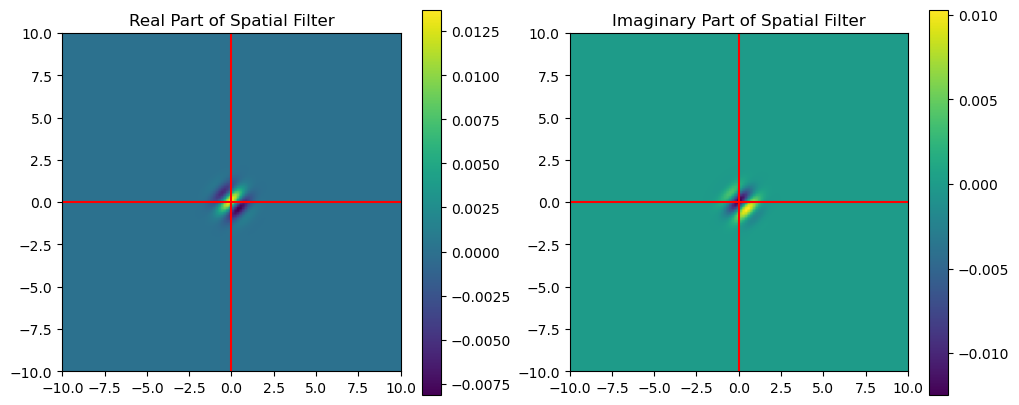

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming definitions for pol2cart, gauss_filter_2d are available and correct

def check_fourier_symmetry(F):
    # Check if the Fourier transform F has Hermitian symmetry
    # F should be a 2D array
    return np.allclose(F, np.conj(np.flipud(np.fliplr(F))))

def test_filter():
    # Grid setup
    space = np.linspace(-10, 10, num=128)
    time = np.linspace(-10, 10, num=128)
    xs, ys = np.meshgrid(space, time)

    # Filter parameters
    scale = 2
    orientation = np.pi/4  #np.pi / 4  # 45 degrees

    # Generate filter in Fourier space
    fourier_filter = quadrature_gaussian_filter(xs, ys, scale, orientation)

    # Check symmetry
    symmetric = check_fourier_symmetry(np.abs(fourier_filter))
    print(f"Fourier filter is symmetric: {symmetric}")
    
    # Transform to spatial domain
    filter_real, filter_imag = inverse_power_spec(fourier_filter)
    #spatial_filter = np.fft.ifft2(np.fft.ifftshift(fourier_filter))
    #spatial_filter = np.fft.fftshift(spatial_filter)
    #filter_real = np.real(spatial_filter)
    #filter_imag = np.imag(spatial_filter)

    # Plot results
    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    plt.imshow(filter_real, extent=(space.min(), space.max(), time.min(), time.max()))
    plt.axhline(0,color='red') # x = 0
    plt.axvline(0,color='red') # y = 0
    plt.title('Real Part of Spatial Filter')
    plt.colorbar()

    plt.subplot(122)
    plt.imshow(filter_imag, extent=(space.min(), space.max(), time.min(), time.max()))
    plt.axhline(0,color='red') # x = 0
    plt.axvline(0,color='red') # y = 0
    plt.title('Imaginary Part of Spatial Filter')
    plt.colorbar()

    plt.show()

test_filter()

/state/partition1/slurm_tmp/26443615.0.0/ipykernel_2763179/2640904726.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(len(orientations),len(scales),i*len(scales)+j+1, aspect=0.5)


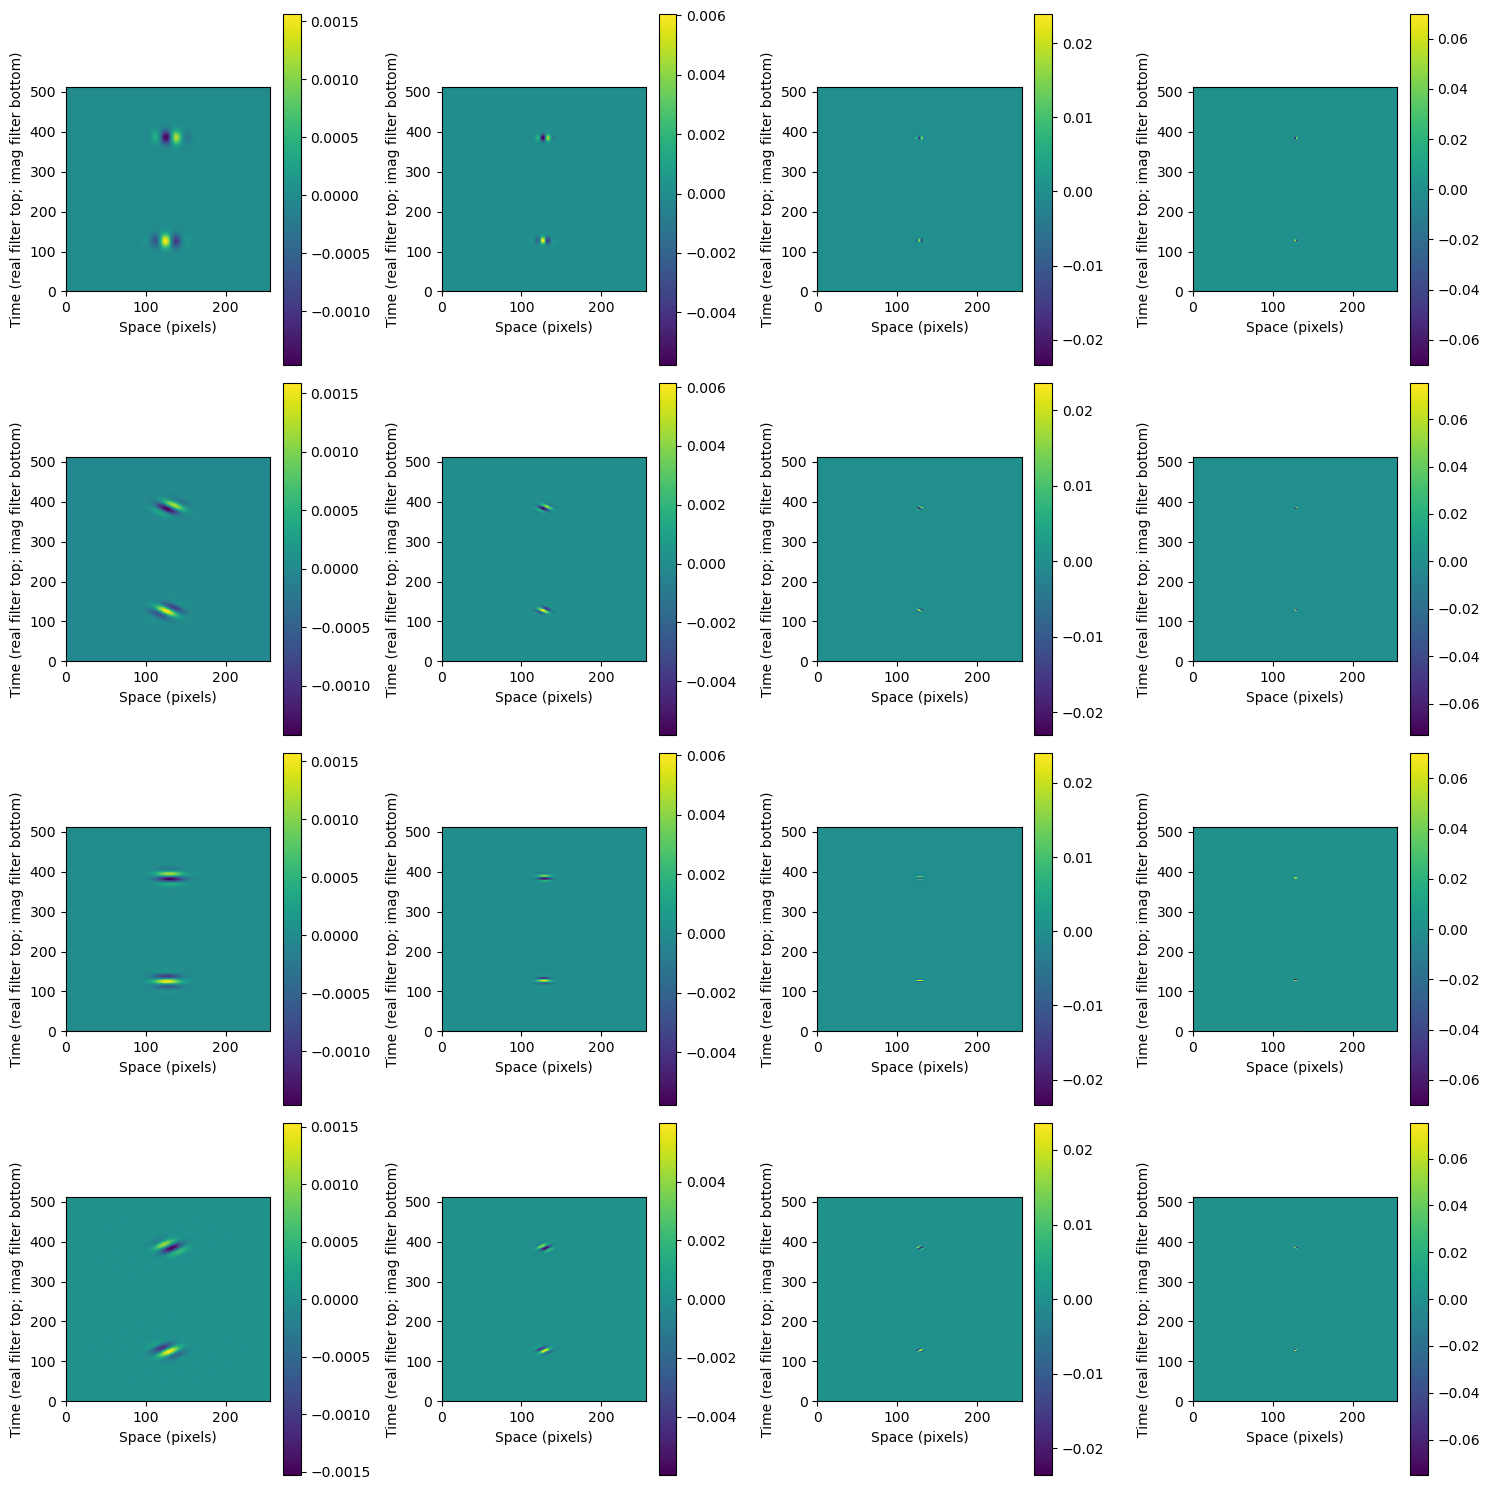

In [9]:
#pick our scales & centers
scales = [2,4,8,16]
orientations = [0,pi/4,pi/2,3*pi/4]
space = np.linspace(-30,30,num=256)
time = np.linspace(-30,30,num=256)
xs,ys = np.meshgrid(space,time)

#plot these all
fig,ax = plt.subplots(figsize=(15,15))
for i, orientation in enumerate(orientations):
    for j, scale in enumerate(scales):
        #create filter
        fourier_footprint = quadrature_gaussian_filter(xs,ys,scale,orientation)
        filter_real, filter_imag = inverse_power_spec(fourier_footprint)
        filter_pair = np.concatenate((filter_real, filter_imag), axis=0)
        #plot it
        plt.subplot(len(orientations),len(scales),i*len(scales)+j+1, aspect=0.5)
        plt.pcolormesh(filter_pair)
        plt.colorbar()
        #plt.pcolormesh(space, time, filter, cmap='Greys_r')
        #plt.contour(xs, ys, filter, levels=[np.max(filter) / 2], colors='red', linestyles='-', linewidths=2)
        #plt.pcolormesh(space, time, filter, shading='auto',cmap='Greys_r')
        #plt.fill_between(x, y, where=((x > half_max_x1) & (x < half_max_x2)), color='gray', alpha=0.5, label='FWHM Area')
        #plt.axvline(half_max_x1, color='b', linestyle='--', label='FWHM Boundaries')
        plt.xlabel('Space (pixels)')
        plt.ylabel('Time (real filter top; imag filter bottom)')
        #plt.colorbar()
        plt.tight_layout()
